In [1]:
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNetV2, VGG16
from tensorflow.keras.layers import Conv2D, Flatten, Dropout, BatchNormalization, Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, array_to_img, img_to_array


In [ ]:
import kagglehub
import os
import pandas as pd

# Download the latest version of the dataset
path = kagglehub.dataset_download("crowww/a-large-scale-fish-dataset")

print("Path to dataset files:", path)

label = []
image_paths = []

# Walk through the directory where the dataset was downloaded
for dir_name, _, filenames in os.walk(path):
    # Ignore directories ending with 'GT' (Ground Truth annotations)
    if os.path.basename(dir_name) != 'GT':
        # Only process .png files
        for filename in filenames:
            if os.path.splitext(filename)[-1] == '.png':
                label.append(os.path.basename(dir_name))  # Use the folder name as label
                image_paths.append(os.path.join(dir_name, filename))

# Create the DataFrame
data = pd.DataFrame({'path': image_paths, 'label': label})

# Show the DataFrame
data


Path to dataset files: /root/.cache/kagglehub/datasets/crowww/a-large-scale-fish-dataset/versions/2


In [ ]:
data.label.value_counts().sort_values(ascending=False)

Error loading image /root/.cache/kagglehub/datasets/crowww/a-large-scale-fish-dataset/versions/2/Fish_Dataset/Fish_Dataset/Sea Bass/Sea Bass GT/00822.png: num must be an integer with 1 <= num <= 9, not 10
Error loading image /root/.cache/kagglehub/datasets/crowww/a-large-scale-fish-dataset/versions/2/Fish_Dataset/Fish_Dataset/Sea Bass/Sea Bass/00822.png: num must be an integer with 1 <= num <= 9, not 10
Error loading image /root/.cache/kagglehub/datasets/crowww/a-large-scale-fish-dataset/versions/2/Fish_Dataset/Fish_Dataset/Shrimp/Shrimp GT/00822.png: num must be an integer with 1 <= num <= 9, not 10
Error loading image /root/.cache/kagglehub/datasets/crowww/a-large-scale-fish-dataset/versions/2/Fish_Dataset/Fish_Dataset/Red Sea Bream/Red Sea Bream GT/00822.png: num must be an integer with 1 <= num <= 9, not 10
Error loading image /root/.cache/kagglehub/datasets/crowww/a-large-scale-fish-dataset/versions/2/Fish_Dataset/Fish_Dataset/Red Sea Bream/Red Sea Bream/00822.png: num must be an 

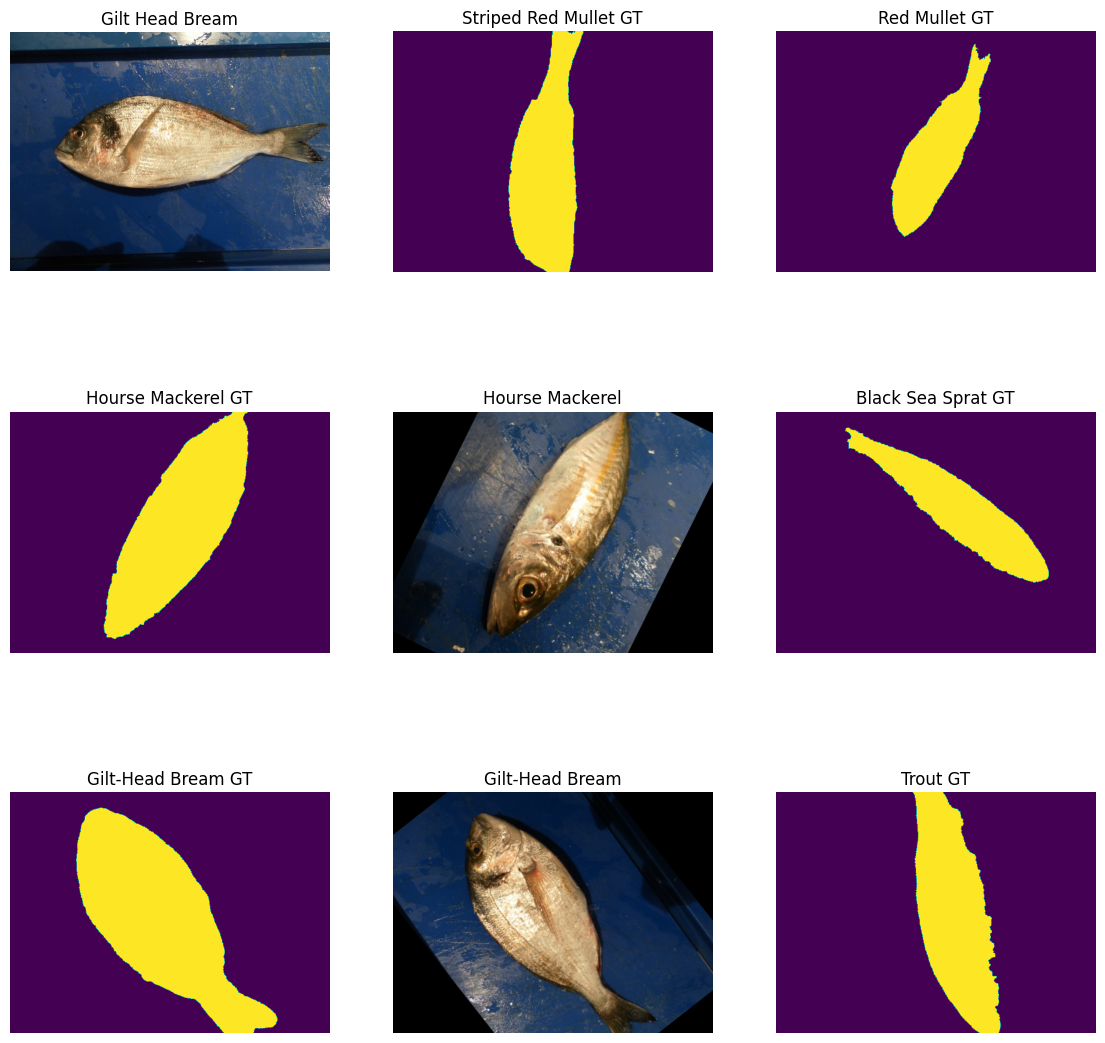

In [4]:

import matplotlib.image as mpimg  # Import mpimg to handle image reading

cn = 0

plt.figure(figsize=(14, 14))

# Iterate over unique labels (categories of fish)
for unique_label in data['label'].unique():
    try:
        # Get the first image corresponding to the current label
        img_path = data[data['label'] == unique_label].iloc[0, 0]

        # Load the image
        img = mpimg.imread(img_path)

        # Plot the image
        plt.subplot(3, 3, cn + 1)
        plt.imshow(img)
        plt.title(unique_label)
        plt.axis('off')

        cn += 1
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")
        continue

plt.show()


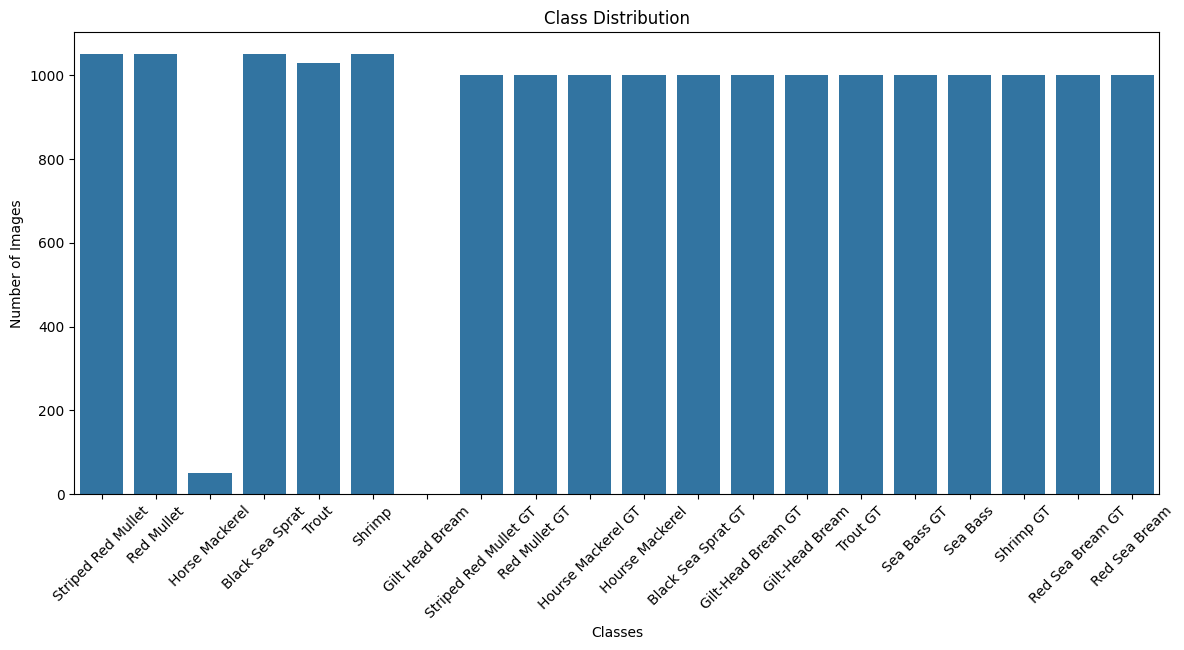

In [5]:
plt.figure(figsize=(14, 6))
sns.countplot(x='label', data=data)
plt.title('Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

In [6]:
# def load_images(image_paths, target_size=(64, 64)):
#     images = [img_to_array(load_img(img, target_size=target_size)) / 255.0 for img in image_paths]
#     return np.array(images)

In [7]:
# image_paths = data['path'].tolist()
# images = load_images(image_paths)

In [8]:
# Splitting the data
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=True, random_state=42)

# Get the number of unique classes
num_classes = len(train_data['label'].unique())

In [9]:
train_data['label'].nunique()

19

In [10]:
# Data Augmentation for the training set
train_generator = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
)

val_generator = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_generator = ImageDataGenerator(rescale=1./255)

# Loading the images using flow_from_dataframe
train_images = train_generator.flow_from_dataframe(
    dataframe=train_data,
    x_col='path',
    y_col='label',
    target_size=(64, 64),  # Updated target size to match input shape
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=True,
    seed=42,
    subset='training'
)
val_images = val_generator.flow_from_dataframe(
    dataframe=train_data,
    x_col='path',
    y_col='label',
    target_size=(64, 64),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=True,
    seed=42,
    subset='validation'
)
test_images = test_generator.flow_from_dataframe(
    dataframe=test_data,
    x_col='path',
    y_col='label',
    target_size=(64, 64),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=False
)


Found 11700 validated image filenames belonging to 19 classes.
Found 2924 validated image filenames belonging to 19 classes.
Found 3657 validated image filenames belonging to 20 classes.


In [11]:
# Building the model
model = Sequential()
model.add(Flatten(input_shape=(64, 64, 3)))  # Input shape should match the target_size
model.add(Dense(512, activation='relu'))  # First hidden layer
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))  # Second hidden layer
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))  # Third hidden layer
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))  # Output layer with softmax for classification


In [12]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
# Train the model using the train_images generator and validate on val_images
history = model.fit(
    train_images,                # Training data generator
    validation_data=val_images,   # Validation data generator
    epochs=10,                    # Number of epochs
    steps_per_epoch=len(train_images),   # Steps per epoch (total batches in the training data)
    validation_steps=len(val_images)     # Validation steps (total batches in the validation data)
)

# Evaluate the model on the test data using the test_images generator
test_loss, test_acc = model.evaluate(test_images, steps=len(test_images))
print(f"Test accuracy: {test_acc}")


Epoch 1/10
183/183 [==============================] - 70s 381ms/step - loss: 0.8150 - accuracy: 0.7013 - val_loss: 0.8168 - val_accuracy: 0.7175
Epoch 2/10
183/183 [==============================] - 69s 380ms/step - loss: 0.7786 - accuracy: 0.7168 - val_loss: 0.7528 - val_accuracy: 0.7278
Epoch 3/10
183/183 [==============================] - 70s 381ms/step - loss: 0.7306 - accuracy: 0.7362 - val_loss: 0.8210 - val_accuracy: 0.7240
Epoch 4/10
183/183 [==============================] - 69s 380ms/step - loss: 0.7015 - accuracy: 0.7421 - val_loss: 0.7351 - val_accuracy: 0.7312
Epoch 5/10
183/183 [==============================] - 70s 382ms/step - loss: 0.6659 - accuracy: 0.7605 - val_loss: 0.8139 - val_accuracy: 0.7131
Epoch 6/10
183/183 [==============================] - 70s 380ms/step - loss: 0.6483 - accuracy: 0.7691 - val_loss: 0.7086 - val_accuracy: 0.7469
Epoch 7/10
183/183 [==============================] - 68s 372ms/step - loss: 0.6060 - accuracy: 0.7792 - val_loss: 0.6706 - val_ac

In [14]:
num_classes_test = test_data['label'].nunique()
print(f"Number of classes in test data: {num_classes_test}")

Number of classes in test data: 20


In [16]:
train_classes = set(train_data['label'].unique())
test_classes = set(test_data['label'].unique())
missing_class = list(test_classes - train_classes)[0]  # Get the missing class
print(f"Missing class in train_data: {missing_class}")

Missing class in train_data: Gilt Head Bream


In [18]:
test_data = test_data[test_data['label'] != missing_class]
# Recreate the test_images generator with the updated test_data
test_images = test_generator.flow_from_dataframe(
    dataframe=test_data,
    x_col='path',
    y_col='label',
    target_size=(64, 64),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=False
)

Found 3656 validated image filenames belonging to 19 classes.


In [ ]:
https://www.kaggle.com/code/canak0/fish-classification
https://www.kaggle.com/code/ckmkemr/fish-classification-with-ann